In [1]:
#通过添加其他合成特征来改进线性回归模型（这是前一个练习的延续）
#使用输入函数将 Pandas DataFrame 对象转换为 Tensors，并在 fit() 和 predict() 中调用输入函数
#使用 FTRL 优化算法进行模型训练
#通过独热编码、分箱和特征组合创建新的合成特征

In [2]:
#读取数据
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
#permutation随机排列

In [3]:
#处理特征和标签
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
#划分训练集和验证集
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.7,-119.6,28.6,2661.0,543.5,1438.9,505.0,3.9,2.0
std,2.1,2.0,12.7,2195.0,425.8,1168.6,388.4,1.9,1.0
min,32.5,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1468.0,300.0,793.0,283.0,2.6,1.5
50%,34.3,-118.5,29.0,2155.0,438.0,1173.0,412.0,3.5,1.9
75%,37.7,-118.0,37.0,3167.0,653.0,1731.0,609.0,4.8,2.3
max,42.0,-114.5,52.0,32627.0,6445.0,35682.0,6082.0,15.0,52.0


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2602.2,529.6,1407.2,492.2,3.9,2.0
std,2.1,2.0,12.4,2143.0,410.8,1096.2,374.9,1.9,1.5
min,32.6,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.6,18.0,1446.0,291.0,781.0,276.0,2.6,1.5
50%,34.2,-118.5,29.0,2075.5,424.0,1153.0,400.0,3.5,1.9
75%,37.7,-118.0,37.0,3108.2,637.0,1697.5,595.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


Training targets summary:


,median_house_value
count,12000.0
mean,207.8
std,116.0
min,15.0
25%,119.9
50%,180.9
75%,265.4
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.1
std,116.0
min,22.5
25%,118.5
50%,178.8
75%,264.1
max,500.0


In [5]:
#构建特征
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
#将特征从panda转换成tf接受的格式
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
? tf.contrib.estimator.clip_gradients_by_norm() #裁剪梯度防止爆炸
? Dataset.shuffle() #传buffersize参数 决定在多大的buffer里shuffle


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [8]:
#高维度线性模型可受益于使用一种基于梯度的优化方法，叫做 FTRL。
#优化器选用了 FTRL，该算法的优势是针对不同系数以不同方式调整学习速率，
#如果某些特征很少采用非零值，该算法可能比较实用（也非常适合支持 L1 正则化）。
#之前是feature_columns=construct_feature_columns(training_examples)，现在是传入feature_columns参数
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  # clip_gradients_by_norm() Returns an optimizer which clips gradients before applying them. 
  # 进行裁剪，确保数值稳定性以及防止梯度爆炸。
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
  plt.show()
  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 203.83
  period 01 : 119.56
  period 02 : 252.56
  period 03 : 211.12
  period 04 : 175.62
  period 05 : 136.53
  period 06 : 154.53
  period 07 : 152.02
  period 08 : 126.29
  period 09 : 115.39
Model training finished.


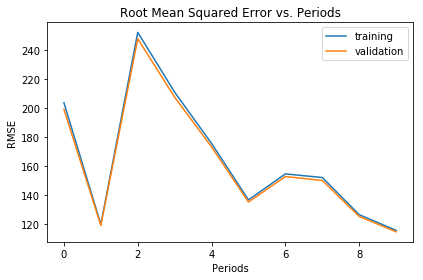

In [9]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [11]:
#会根据分位数计算边界，以便每个分桶包含相同数量的元素。
def get_quantile_based_boundaries(feature_values, num_buckets):
  #arange返回结果是ndarray
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

In [12]:
# Return evenly spaced values within a given interval.
?np.arange()

In [13]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  # 要为分桶特征定义特征列，我们可以使用 bucketized_column
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))

  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 5))
    
  bucketized_median_income =tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 15))

  bucketized_rooms_per_person =tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 5))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns


Training model...
RMSE (on training data):
  period 00 : 170.32
  period 01 : 143.80
  period 02 : 127.15
  period 03 : 115.78
  period 04 : 107.63
  period 05 : 101.67
  period 06 : 96.99
  period 07 : 93.34
  period 08 : 90.36
  period 09 : 87.83
Model training finished.


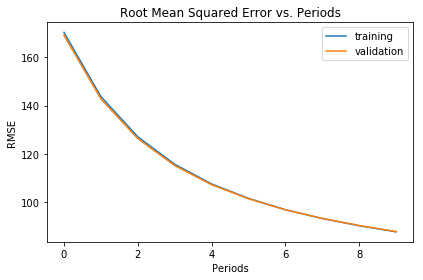

In [15]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [19]:
#如果我们将 longitude 与 latitude 组合，产生的组合特征则代表一个明确的城市街区。
#如果模型发现某些城市街区更可能比其他街区住房成本高昂，那么这将是比单独考虑两个特征更强烈的信号。
#特征列 API 仅支持组合离散特征。要组合两个连续的值（比如 latitude 或 longitude），我们可以对其进行分桶
#如果我们组合 latitude 和 longitude 特征（例如，假设 longitude 被分到 2 个分桶中，
#而 latitude 有 3 个分桶），我们实际上会得到 6 个组合的二元特征。
#当我们训练模型时，每个特征都会分别获得自己的权重。
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  # !!!!!Make a feature column for the long_x_lat feature cross
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 163.60
  period 01 : 135.19
  period 02 : 117.97
  period 03 : 106.45
  period 04 : 98.29
  period 05 : 92.29
  period 06 : 87.68
  period 07 : 83.94
  period 08 : 81.02
  period 09 : 78.58
Model training finished.


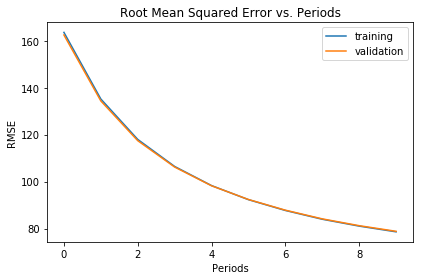

In [20]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)